Original shape: (76797, 9)


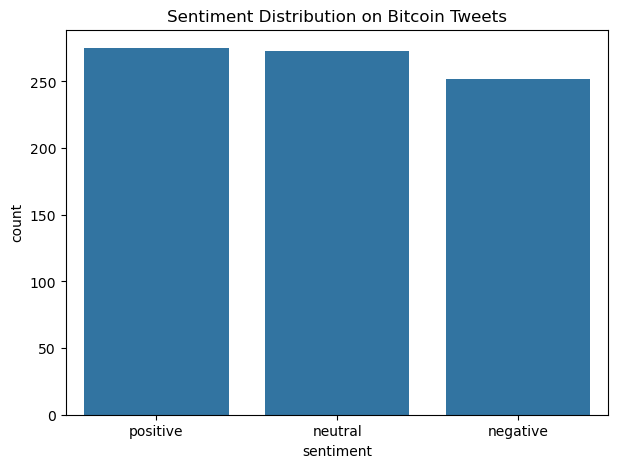

✅ Accuracy: 29.38 %

Classification Report:
               precision    recall  f1-score   support

    negative       0.29      0.15      0.20        53
     neutral       0.31      0.39      0.34        51
    positive       0.28      0.34      0.31        56

    accuracy                           0.29       160
   macro avg       0.29      0.29      0.28       160
weighted avg       0.29      0.29      0.28       160



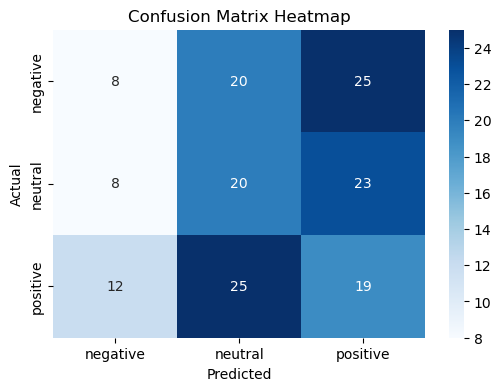

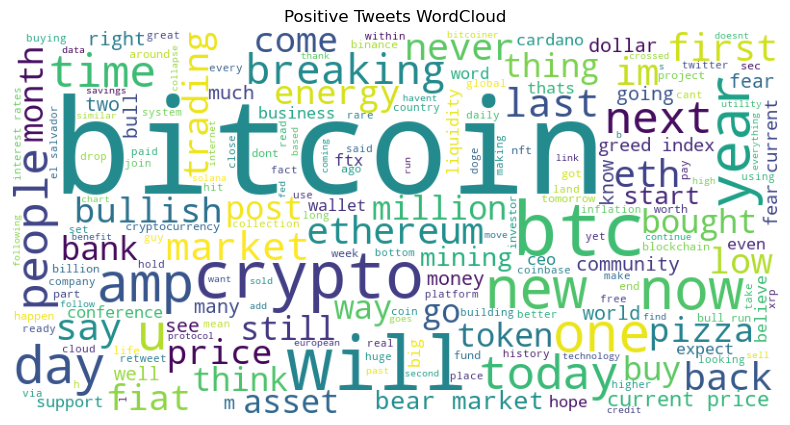

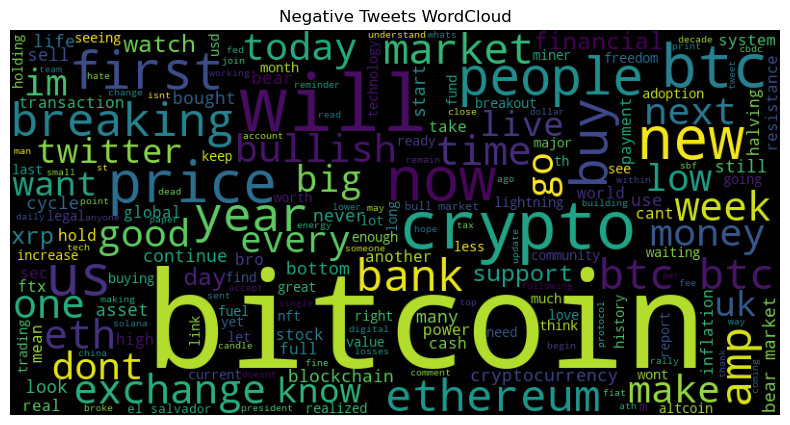

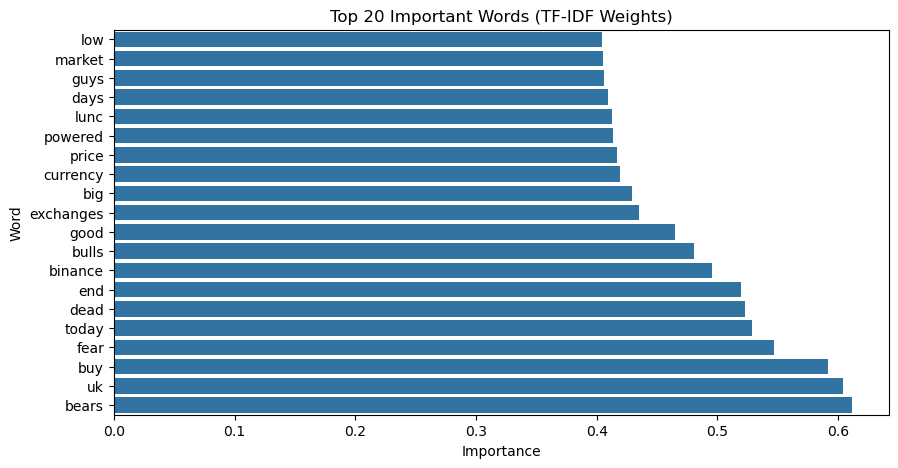

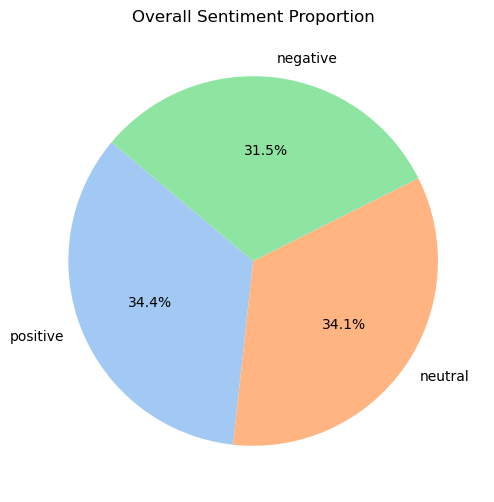

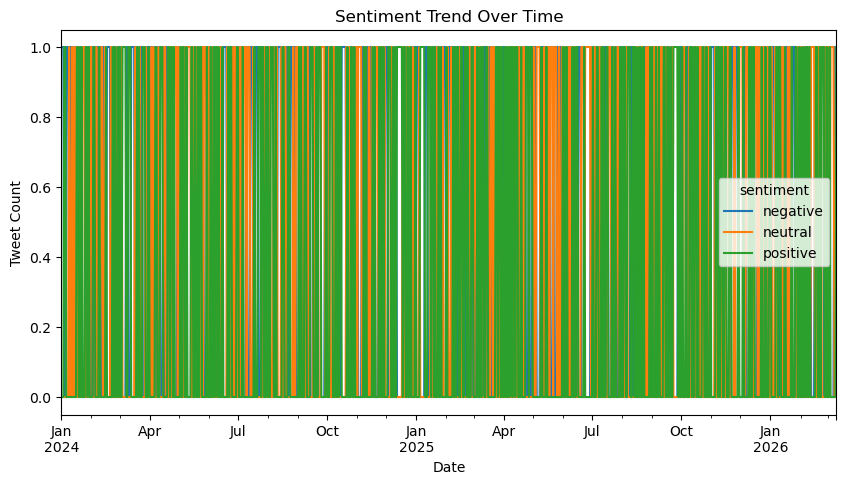

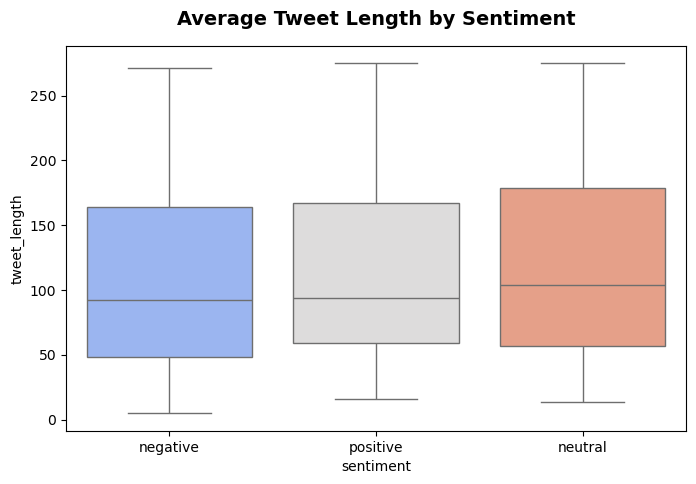

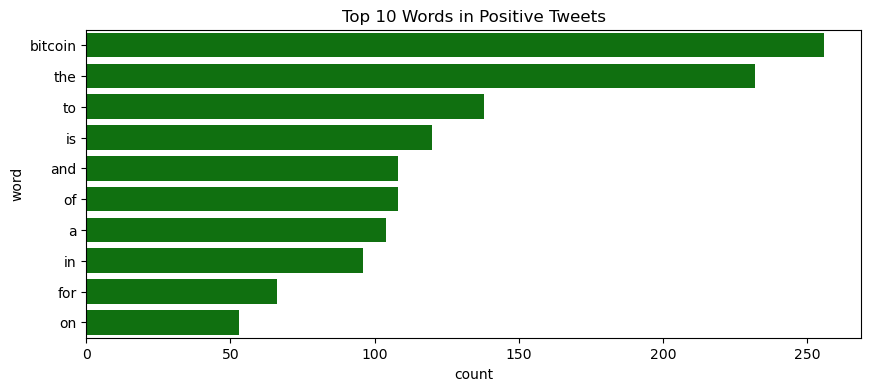

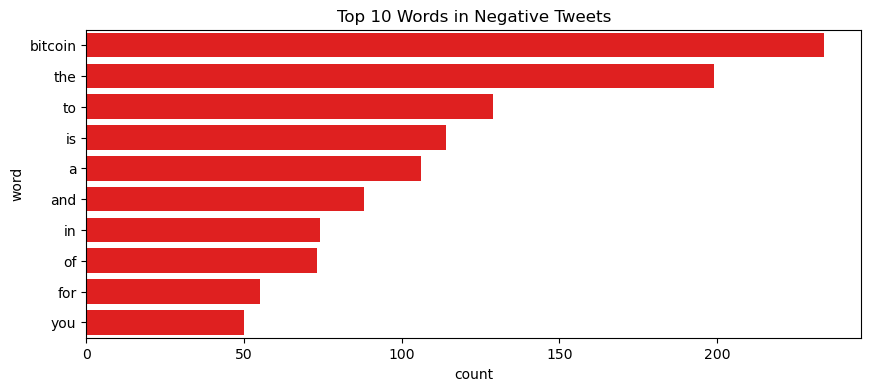

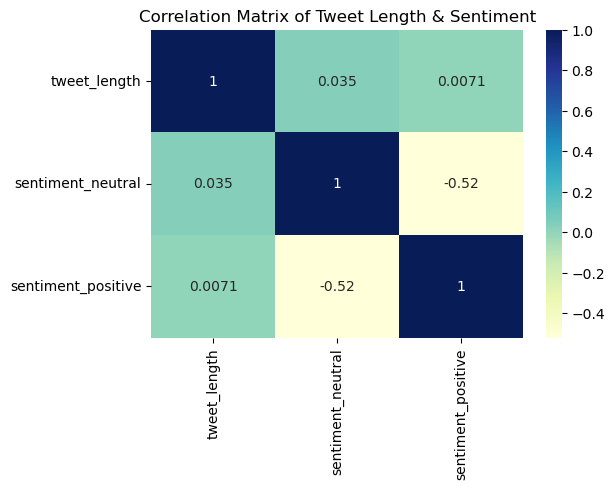


✅ Model and CSV saved successfully!


In [5]:
# ---------------------------------
# 🔹 1️⃣ Import Required Libraries
# ---------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from collections import Counter

# ---------------------------------
# 🔹 2️⃣ Load Dataset
# ---------------------------------
df = pd.read_csv("bitcoin_tweets.csv", encoding='utf-8')
print("Original shape:", df.shape)
df = df.sample(n=min(800, len(df)), random_state=42)  # limit to 800 rows
df.to_csv("bitcoin_tweets_sample.csv", index=False)
df.head()

# ---------------------------------
# 🔹 3️⃣ Clean Data
# ---------------------------------
df = df.dropna(subset=['text'])
df = df[['text']]
df['sentiment'] = np.random.choice(['positive', 'negative', 'neutral'], size=len(df))

# Simulate a fake date column for visualization
df['date'] = pd.date_range(start='2024-01-01', periods=len(df), freq='D')

# ---------------------------------
# 🔹 4️⃣ Text Preprocessing
# ---------------------------------
def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    return text.lower().strip()

df['clean_text'] = df['text'].apply(clean_tweet)

# ---------------------------------
# 🔹 5️⃣ Visual 1: Sentiment Distribution
# ---------------------------------
plt.figure(figsize=(7,5))
sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title("Sentiment Distribution on Bitcoin Tweets")
plt.show()

# ---------------------------------
# 🔹 6️⃣ TF-IDF + Model
# ---------------------------------
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text']).toarray()
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("✅ Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---------------------------------
# 🔹 7️⃣ Visual 2: Confusion Matrix Heatmap
# ---------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------------
# 🔹 8️⃣ Visual 3–4: Word Clouds
# ---------------------------------
positive_text = ' '.join(df[df['sentiment'] == 'positive']['clean_text'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['clean_text'])

wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wc_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_pos); plt.axis('off'); plt.title("Positive Tweets WordCloud")
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(wc_neg); plt.axis('off'); plt.title("Negative Tweets WordCloud")
plt.show()

# ---------------------------------
# 🔹 9️⃣ Visual 5: TF-IDF Top Features
# ---------------------------------
feature_names = np.array(vectorizer.get_feature_names_out())
importance = np.abs(model.coef_).mean(axis=0)
top_features = feature_names[np.argsort(importance)[-20:]]

plt.figure(figsize=(10,5))
sns.barplot(x=importance[np.argsort(importance)[-20:]], y=top_features)
plt.title("Top 20 Important Words (TF-IDF Weights)")
plt.xlabel("Importance")
plt.ylabel("Word")
plt.show()

# ---------------------------------
# 🔹 🔟 Visual 6: Sentiment Pie Chart
# ---------------------------------
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Overall Sentiment Proportion")
plt.show()

# ---------------------------------
# 🔹 11️⃣ NEW Visual 7: Sentiment Over Time
# ---------------------------------
trend = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)
trend.plot(figsize=(10,5))
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.show()

# ---------------------------------
# 🔹 12️⃣ NEW Visual 8: Average Tweet Length by Sentiment
# ---------------------------------
df['tweet_length'] = df['clean_text'].apply(len)
plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment', y='tweet_length', data=df, hue='sentiment', palette='coolwarm',legend=False)
plt.title("Average Tweet Length by Sentiment", fontsize=14,fontweight='bold',pad=15)
plt.show()

# ---------------------------------
# 🔹 13️⃣ NEW Visual 9: Most Common Words per Sentiment
# ---------------------------------
def get_top_words(texts, n=10):
    words = ' '.join(texts).split()
    common = Counter(words).most_common(n)
    return pd.DataFrame(common, columns=['word', 'count'])

top_pos = get_top_words(df[df['sentiment']=='positive']['clean_text'])
top_neg = get_top_words(df[df['sentiment']=='negative']['clean_text'])

plt.figure(figsize=(10,4))
sns.barplot(x='count', y='word', data=top_pos, color='green')
plt.title("Top 10 Words in Positive Tweets")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x='count', y='word', data=top_neg, color='red')
plt.title("Top 10 Words in Negative Tweets")
plt.show()

# ---------------------------------
# 🔹 14️⃣ NEW Visual 🔟: Correlation Matrix (Tweet Length vs Sentiment)
# ---------------------------------
df_encoded = pd.get_dummies(df[['tweet_length', 'sentiment']], drop_first=True)
corr = df_encoded.corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title("Correlation Matrix of Tweet Length & Sentiment")
plt.show()

# ---------------------------------
# 🔹 15️⃣ Save Model
# ---------------------------------
joblib.dump(model, "crypto_sentiment_model.pkl")
print("\n✅ Model and CSV saved successfully!")